In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, sum as _sum, avg as _avg, size, split, substring, length, countDistinct,
    to_date, month, year, date_format, lag, datediff
)
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import to_timestamp
import pandas as pd

In [3]:
spark = SparkSession.builder.appName("YelpUserAnalysis").getOrCreate()

24/11/24 20:33:05 WARN Utils: Your hostname, yelp resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s17)
24/11/24 20:33:05 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/24 20:33:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
business_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_business.json")
review_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_review.json")
user_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_user.json")

24/11/24 20:33:42 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [5]:
# Creating a Base View wwhich gives users that are only relevant to Arizona Nightlife Business Category 
arizona_business_df = business_df.filter((col("state") == "AZ") & (col("categories").contains("Nightlife")))
arizona_business_df.createOrReplaceTempView("business")

review_df.createOrReplaceTempView("review")
user_df.createOrReplaceTempView("user")

business_review_df = review_df.join(arizona_business_df, on="business_id", how="inner")
business_review_df.createOrReplaceTempView("business_review")


In [7]:
# Query 1: Most Influential Users (Useful Votes)
query1 = """
SELECT u.user_id, u.name, SUM(r.useful) AS total_useful_votes
FROM user u
JOIN review r ON u.user_id = r.user_id
JOIN business b ON r.business_id = b.business_id
WHERE b.state = 'AZ' AND b.categories LIKE '%Nightlife%'
GROUP BY u.user_id, u.name
ORDER BY total_useful_votes DESC
LIMIT 10
"""

result1 = spark.sql(query1)
print("Query 1: Most Influential Users (Useful Votes)")
result1.show()

Query 1: Most Influential Users (Useful Votes)


24/11/24 20:36:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 20:36:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 20:36:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 20:36:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 20:36:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 20:36:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 20:36:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 20:36:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 20:36:58 WARN RowBasedKeyValueBatch: Calling spill() on

+--------------------+--------+------------------+
|             user_id|    name|total_useful_votes|
+--------------------+--------+------------------+
|6ObFF8-uKnOAlXuSH...|Isabella|              1158|
|2YKkLFeOx-0zRcWp0...|    Mark|               464|
|W67nXodRWTIa-d1NJ...|    Saba|               415|
|1F5wbSbtUBzxS8IsM...|  Nicole|               329|
|zBWSORvlWDmwtcx66...|   Kathy|               313|
|4kKngcDGjuzo18pxx...|  Amanda|               281|
|Hy_ko_2hkLTxvO7G0...|  Eleana|               253|
|0Hl2BwAIz3Gi3Jhlx...|    Mark|               234|
|JUT0U3HTSB3kz9Wh7...|   Corey|               231|
|Js1FsZ6oP_9tO5tbJ...| Kirsten|               228|
+--------------------+--------+------------------+



In [8]:
# Query 2: Elite User Participation in Nightlife Reviews

# Calculate total users
query2p1 = """
SELECT COUNT(DISTINCT u.user_id) AS total_user_count
FROM user u
JOIN review r ON u.user_id = r.user_id
JOIN business b ON r.business_id = b.business_id
"""

total_user_count = spark.sql(query2p1).collect()[0]['total_user_count']

# Calculate elite users
query2p2 = """
SELECT COUNT(DISTINCT u.user_id) AS elite_user_count
FROM user u
JOIN review r ON u.user_id = r.user_id
JOIN business b ON r.business_id = b.business_id
WHERE length(u.elite) > 0
"""

elite_user_count = spark.sql(query2p2).collect()[0]['elite_user_count']

elite_user_percentage = (elite_user_count * 100.0) / total_user_count

print("\nQuery 2: Elite User Participation in Nightlife Reviews")
print(f"Total Users: {total_user_count}")
print(f"Elite Users: {elite_user_count}")
print(f"Elite User Percentage: {elite_user_percentage:.2f}%")



Query 2: Elite User Participation in Nightlife Reviews
Total Users: 37182
Elite Users: 3603
Elite User Percentage: 9.69%


In [9]:
# Query 3: Distribution of Compliments Received by Users
query3 = """
SELECT u.user_id, u.name,
       SUM(u.compliment_hot + u.compliment_more + u.compliment_profile + u.compliment_cute +
        u.compliment_list + u.compliment_note + u.compliment_plain + u.compliment_cool +
        u.compliment_funny + u.compliment_writer + u.compliment_photos) AS total_compliments
FROM user u
JOIN review r ON u.user_id = r.user_id
JOIN business b ON r.business_id = b.business_id
GROUP BY u.user_id, u.name
ORDER BY total_compliments DESC
LIMIT 10
"""

result3 = spark.sql(query3)
print("\nQuery 3: Distribution of Compliments Received by Users")
result3.show(truncate=False)


Query 3: Distribution of Compliments Received by Users


24/11/24 20:42:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 20:42:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 20:42:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 20:42:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 20:42:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 20:42:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 20:42:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 20:42:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 20:42:14 WARN RowBasedKeyValueBatch: Calling spill() on

+----------------------+--------+-----------------+
|user_id               |name    |total_compliments|
+----------------------+--------+-----------------+
|6ObFF8-uKnOAlXuSH4TlyQ|Isabella|956813           |
|UXbCcmkYGl3DH_Py5UOtbQ|Toni    |656672           |
|h4oOQdnfjpEHbygEJDsFbg|John    |264064           |
|JUT0U3HTSB3kz9Wh7N0GqA|Corey   |242051           |
|5BpJEC8YVi80ecWT5CtlfQ|Jenny   |229102           |
|DK57YibC5ShBmqQl97CKog|Karen   |182940           |
|2YKkLFeOx-0zRcWp0KUv_Q|Mark    |142862           |
|aHl-3UItyhhS9P40Nr9EaA|Monica  |119206           |
|1F5wbSbtUBzxS8IsM7fWsA|Nicole  |114818           |
|zBWSORvlWDmwtcx6627qWQ|Kathy   |76884            |
+----------------------+--------+-----------------+



In [10]:
# Query 4: Users Active Since Earliest Years
query4 = """
SELECT SUBSTRING(u.yelping_since, 1, 4) AS join_year, COUNT(DISTINCT u.user_id) AS user_count
FROM user u
JOIN review r ON u.user_id = r.user_id
JOIN business b ON r.business_id = b.business_id
GROUP BY SUBSTRING(u.yelping_since, 1, 4)
ORDER BY join_year ASC
"""

result4 = spark.sql(query4)
print("\nQuery 4: Users Active Since Earliest Years")
result4.show()


Query 4: Users Active Since Earliest Years


24/11/24 20:44:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 20:44:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 20:44:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 20:44:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 20:44:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 20:44:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 20:44:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 20:44:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 20:44:04 WARN RowBasedKeyValueBatch: Calling spill() on

+---------+----------+
|join_year|user_count|
+---------+----------+
|     2004|         1|
|     2005|        25|
|     2006|       158|
|     2007|       362|
|     2008|       809|
|     2009|      1379|
|     2010|      2420|
|     2011|      4007|
|     2012|      4175|
|     2013|      4310|
|     2014|      4565|
|     2015|      4263|
|     2016|      3622|
|     2017|      2432|
|     2018|      2004|
|     2019|      1475|
|     2020|       621|
|     2021|       532|
|     2022|        22|
+---------+----------+



In [11]:
# Query 5: Users with the Most Compliments (Including Years on Yelp)
query5 = """
SELECT u.user_id, u.name,
       (u.compliment_hot + u.compliment_more + u.compliment_profile + u.compliment_cute +
        u.compliment_list + u.compliment_note + u.compliment_plain + u.compliment_cool +
        u.compliment_funny + u.compliment_writer + u.compliment_photos) AS total_compliments,
       u.yelping_since
FROM user u
JOIN review r ON u.user_id = r.user_id
JOIN business b ON r.business_id = b.business_id
GROUP BY u.user_id, u.name, u.yelping_since,
         u.compliment_hot,
         u.compliment_more,
         u.compliment_profile,
         u.compliment_cute,
         u.compliment_list,
         u.compliment_note,
         u.compliment_plain,
         u.compliment_cool,
         u.compliment_funny,
         u.compliment_writer,
         u.compliment_photos
ORDER BY total_compliments DESC
LIMIT 10
"""

result5 = spark.sql(query5)
print("\nQuery 5: Users with the Most Compliments (Including Years on Yelp)")
result5.show(truncate=False)


Query 5: Users with the Most Compliments (Including Years on Yelp)

+----------------------+--------+-----------------+-------------------+
|user_id               |name    |total_compliments|yelping_since      |
+----------------------+--------+-----------------+-------------------+
|h4oOQdnfjpEHbygEJDsFbg|John    |132032           |2006-09-11 23:37:44|
|UXbCcmkYGl3DH_Py5UOtbQ|Toni    |82084            |2007-10-04 05:06:32|
|w-w-k-QXosIKQ8HQVwU6IQ|Anthony |60237            |2009-03-13 21:18:34|
|hizGc5W1tBHPghM5YKCAtg|Katie   |49812            |2009-05-22 20:19:55|
|I-4KVZ9lqHhk8469X9FvhA|Susan   |47484            |2017-07-11 18:41:14|
|DK57YibC5ShBmqQl97CKog|Karen   |36588            |2006-01-28 01:56:23|
|hWDybu_KvYLSdEFzGrniTw|Bruce   |34833            |2009-03-08 21:47:44|
|fDny65qdxn3EJH0PZbCxIw|Jennifer|27354            |2006-12-25 04:43:16|
|A0j21z2Q1HGic7jW6e9h7A|Georgie |26158            |2010-07-02 16:21:38|
|UVxY0iyPaqY7s4BSFtt-xA|Wanugee |20969            |2007-06-11 03:54:14|
+----------------------+--------+-----------------+-------------

In [12]:
# Query 6: Frequency of Reviews Per User - Top Users

Query = """
SELECT u.user_id, u.name, COUNT(r.review_id) AS total_reviews
FROM user u
JOIN review r ON u.user_id = r.user_id
JOIN business b ON r.business_id = b.business_id
GROUP BY u.user_id, u.name
ORDER BY total_reviews DESC
LIMIT 10
"""

top_users = spark.sql(Query)
print("Top Users by Number of Reviews")
top_users.show()

top_user_ids = [row['user_id'] for row in top_users.collect()]

# Filter reviews to include only top users
top_users_reviews = review_df.join(business_df, on='business_id') \
    .filter(col('user_id').isin(top_user_ids)) \
    .select('user_id', 'date')


top_users_reviews = top_users_reviews.withColumn('review_timestamp', to_timestamp('date', 'yyyy-MM-dd HH:mm:ss'))
top_users_reviews = top_users_reviews.withColumn('review_date', to_date('review_timestamp'))
window_spec = Window.partitionBy('user_id').orderBy('review_date')
top_users_reviews = top_users_reviews.withColumn('prev_review_date', lag('review_date').over(window_spec))
top_users_reviews = top_users_reviews.withColumn(
    'days_since_last_review',
    datediff('review_date', 'prev_review_date')
)
top_users_reviews_filtered = top_users_reviews.filter(col('days_since_last_review').isNotNull())
avg_days_between_reviews = top_users_reviews_filtered.groupBy('user_id') \
    .agg(_avg('days_since_last_review').alias('avg_days_between_reviews'))

avg_days_between_reviews = avg_days_between_reviews.join(user_df.select('user_id', 'name'), on='user_id', how='left')

# Show results
print("Average Days Between Reviews for Top Users")
avg_days_between_reviews.select('user_id', 'name', 'avg_days_between_reviews').show(truncate=False)


Top Users by Number of Reviews


24/11/24 20:47:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 20:47:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 20:47:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 20:47:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 20:47:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 20:47:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 20:47:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 20:47:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 20:47:16 WARN RowBasedKeyValueBatch: Calling spill() on

+--------------------+--------+-------------+
|             user_id|    name|total_reviews|
+--------------------+--------+-------------+
|W67nXodRWTIa-d1NJ...|    Saba|          147|
|6ObFF8-uKnOAlXuSH...|Isabella|          143|
|2YKkLFeOx-0zRcWp0...|    Mark|          122|
|9Y1YkloHk2MAE3hkw...|    Gene|          114|
|lHqA_D7nAK9xw_Xg0...|  Bianca|          101|
|ig0NAzZ9J_6cF0gCh...|   Mandy|           96|
|4kKngcDGjuzo18pxx...|  Amanda|           93|
|zBWSORvlWDmwtcx66...|   Kathy|           86|
|dvu83QWKsnnbGvNVQ...| William|           84|
|mVtmlFPxA8cBzhaum...|  Doreen|           81|
+--------------------+--------+-------------+



24/11/24 20:49:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 20:49:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 20:49:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 20:49:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 20:49:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 20:49:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 20:49:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 20:49:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 20:49:02 WARN RowBasedKeyValueBatch: Calling spill() on

Average Days Between Reviews for Top Users


+----------------------+--------+------------------------+
|user_id               |name    |avg_days_between_reviews|
+----------------------+--------+------------------------+
|2YKkLFeOx-0zRcWp0KUv_Q|Mark    |8.606924643584522       |
|4kKngcDGjuzo18pxx5jHog|Amanda  |12.826625386996904      |
|6ObFF8-uKnOAlXuSH4TlyQ|Isabella|4.354090354090354       |
|9Y1YkloHk2MAE3hkwYdFKA|Gene    |6.2949308755760365      |
|W67nXodRWTIa-d1NJlncvA|Saba    |10.071078431372548      |
|dvu83QWKsnnbGvNVQ3mv7A|William |6.8821218074656185      |
|ig0NAzZ9J_6cF0gChtvJuA|Mandy   |7.425101214574899       |
|lHqA_D7nAK9xw_Xg08dM_w|Bianca  |12.385507246376811      |
|mVtmlFPxA8cBzhaumweIIA|Doreen  |9.945054945054945       |
|zBWSORvlWDmwtcx6627qWQ|Kathy   |11.369636963696369      |
+----------------------+--------+------------------------+



In [13]:
# Query 7: Users Reviewing Businesses with High Popularity

query7 = """
SELECT u.user_id, u.name, COUNT(r.review_id) AS total_reviews_written,
       AVG(b.review_count) AS avg_business_review_count
FROM user u
JOIN review r ON u.user_id = r.user_id
JOIN business b ON r.business_id = b.business_id
GROUP BY u.user_id, u.name
HAVING COUNT(r.review_id) > 1
ORDER BY avg_business_review_count DESC
LIMIT 10
"""

result1 = spark.sql(query1)
print("Query 7: Users Reviewing Businesses with High Popularity")
result1.show(truncate=False)


Query 7: Users Reviewing Businesses with High Popularity


24/11/24 20:51:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 20:51:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 20:51:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 20:51:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 20:51:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 20:51:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 20:51:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 20:51:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 20:51:35 WARN RowBasedKeyValueBatch: Calling spill() on

+----------------------+--------+------------------+
|user_id               |name    |total_useful_votes|
+----------------------+--------+------------------+
|6ObFF8-uKnOAlXuSH4TlyQ|Isabella|1158              |
|2YKkLFeOx-0zRcWp0KUv_Q|Mark    |464               |
|W67nXodRWTIa-d1NJlncvA|Saba    |415               |
|1F5wbSbtUBzxS8IsM7fWsA|Nicole  |329               |
|zBWSORvlWDmwtcx6627qWQ|Kathy   |313               |
|4kKngcDGjuzo18pxx5jHog|Amanda  |281               |
|Hy_ko_2hkLTxvO7G0pIGsw|Eleana  |253               |
|0Hl2BwAIz3Gi3Jhlx7AYZA|Mark    |234               |
|JUT0U3HTSB3kz9Wh7N0GqA|Corey   |231               |
|Js1FsZ6oP_9tO5tbJN-d2g|Kirsten |228               |
+----------------------+--------+------------------+



Query 8: Seasonal Trends in User Review Activity


+-----+------------+
|month|review_count|
+-----+------------+
|    1|        7142|
|    2|        6974|
|    3|        7176|
|    4|        6558|
|    5|        6410|
|    6|        6431|
|    7|        6297|
|    8|        6499|
|    9|        6071|
|   10|        6308|
|   11|        5976|
|   12|        6055|
+-----+------------+



/tmp/ipykernel_5734/762611231.py:22: FutureWarning:                             

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='month', y='review_count', data=monthly_reviews_df, palette='viridis')


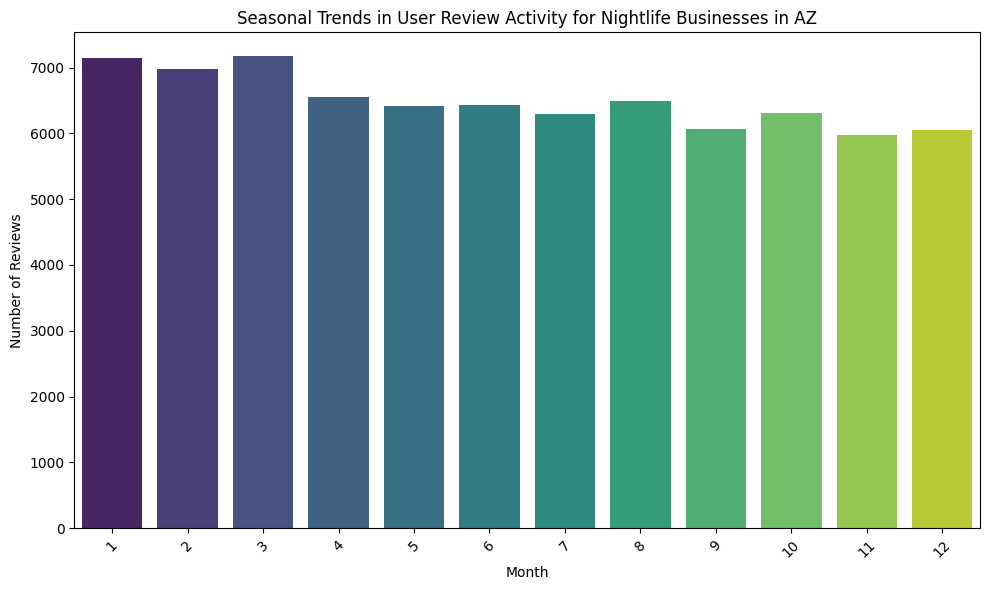

In [14]:
# Query 8: Seasonal Trends in User Review Activity

review_df = review_df.withColumn('review_timestamp', to_timestamp('date', 'yyyy-MM-dd HH:mm:ss'))
review_df = review_df.withColumn('month', month('review_timestamp'))
review_df.createOrReplaceTempView('review')

query8 = """
SELECT month, COUNT(*) as review_count
FROM review r
JOIN business b ON r.business_id = b.business_id
GROUP BY month
ORDER BY month
"""

result2 = spark.sql(query8)
print("Query 8: Seasonal Trends in User Review Activity")
result2.show()

monthly_reviews_df = result2.toPandas()

plt.figure(figsize=(10,6))
sns.barplot(x='month', y='review_count', data=monthly_reviews_df, palette='viridis')
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.title('Seasonal Trends in User Review Activity for Nightlife Businesses in AZ')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Query 9: Users' Friends Count and Average Star Ratings


+--------------------+---------+-------------+-----------------+
|             user_id|     name|friends_count|  avg_stars_given|
+--------------------+---------+-------------+-----------------+
|--A15Rp8LJspfurcz...|    Jared|            1|              5.0|
|-02vN1X2Hre7rF8vr...|     Lori|            1|              5.0|
|-073IXD_JkLK8SlRc...|   Philip|            7|             3.25|
|-07yWKUBuH1hTBF8T...|     Yogi|           68|              2.5|
|-0IiMAZI2SsQ7Vmyz...|Christine|          694|              3.0|
|-0cyhKgBTOGdAG9rW...|   Roslyn|            1|              4.0|
|-0gGKoXBiMnlMuISW...|     Kade|          188|4.333333333333333|
|-10r3AxaqtewrR2dx...|   Victor|            1|              5.0|
|-2TWjxYpKd_2N2cdw...|       KC|          723|              2.5|
|-3s52C4zL_DHRK0UL...|     Sara|           18|              1.0|
+--------------------+---------+-------------+-----------------+
only showing top 10 rows



24/11/24 20:54:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 20:54:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 20:54:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 20:54:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 20:54:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 20:54:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 20:54:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 20:54:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/11/24 20:54:54 WARN RowBasedKeyValueBatch: Calling spill() on

Correlation between number of friends and average stars given: 0.0485


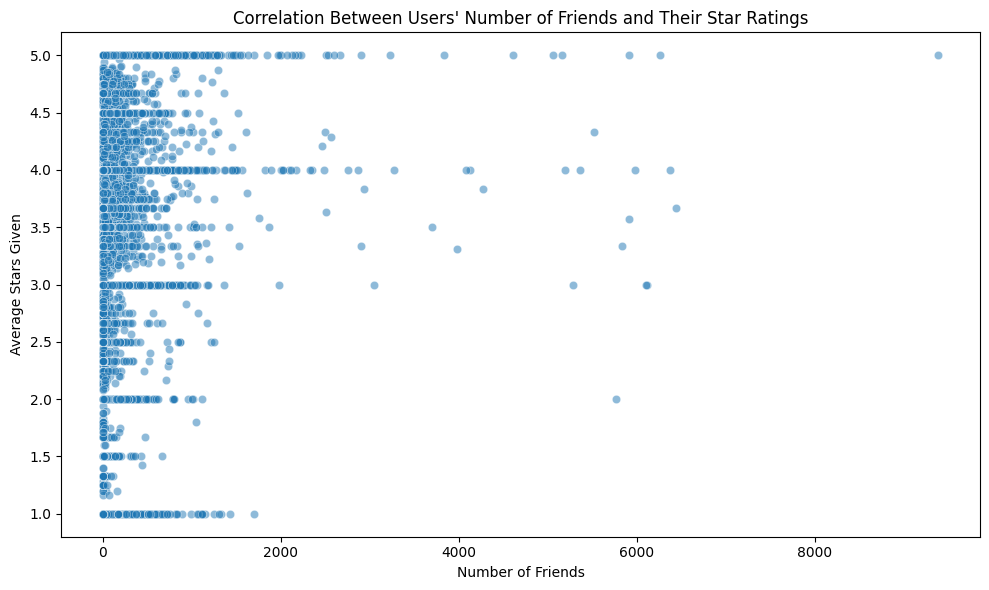

In [15]:
# Query 9: Correlation Between Users' Number of Friends and Their Star Ratings

user_df = user_df.withColumn('friends_count', size(split(col('friends'), ',')))
user_df.createOrReplaceTempView('user')

query9 = """
SELECT u.user_id, u.name, u.friends_count, AVG(r.stars) AS avg_stars_given
FROM user u
JOIN review r ON u.user_id = r.user_id
JOIN business b ON r.business_id = b.business_id
GROUP BY u.user_id, u.name, u.friends_count
"""

result3 = spark.sql(query9)
print("Query 9: Users' Friends Count and Average Star Ratings")
result3.show(10)

friends_stars_df = result3.toPandas()
friends_stars_df = friends_stars_df.dropna()
friends_stars_df['friends_count'] = friends_stars_df['friends_count'].astype(int)
friends_stars_df['avg_stars_given'] = friends_stars_df['avg_stars_given'].astype(float)


correlation = friends_stars_df['friends_count'].corr(friends_stars_df['avg_stars_given'])
print(f"Correlation between number of friends and average stars given: {correlation:.4f}")

# Scatter plot
plt.figure(figsize=(10,6))
sns.scatterplot(x='friends_count', y='avg_stars_given', data=friends_stars_df, alpha=0.5)
plt.xlabel('Number of Friends')
plt.ylabel('Average Stars Given')
plt.title('Correlation Between Users\' Number of Friends and Their Star Ratings')
plt.tight_layout()
plt.show()


Query 10: Geographical Distribution of Users Based on Review Activity


+---------------+----------+
|           city|user_count|
+---------------+----------+
|         Tucson|     35812|
|     Oro Valley|      1864|
|         Marana|       342|
|      Sahuarita|       250|
|           Vail|       236|
|       Catalina|        84|
|   Green Valley|        47|
|         Tuscon|        38|
|Tucson, Arizona|         8|
+---------------+----------+



/tmp/ipykernel_5734/4281886078.py:19: FutureWarning:                            

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='city', y='user_count', data=top_cities_df, palette='coolwarm')


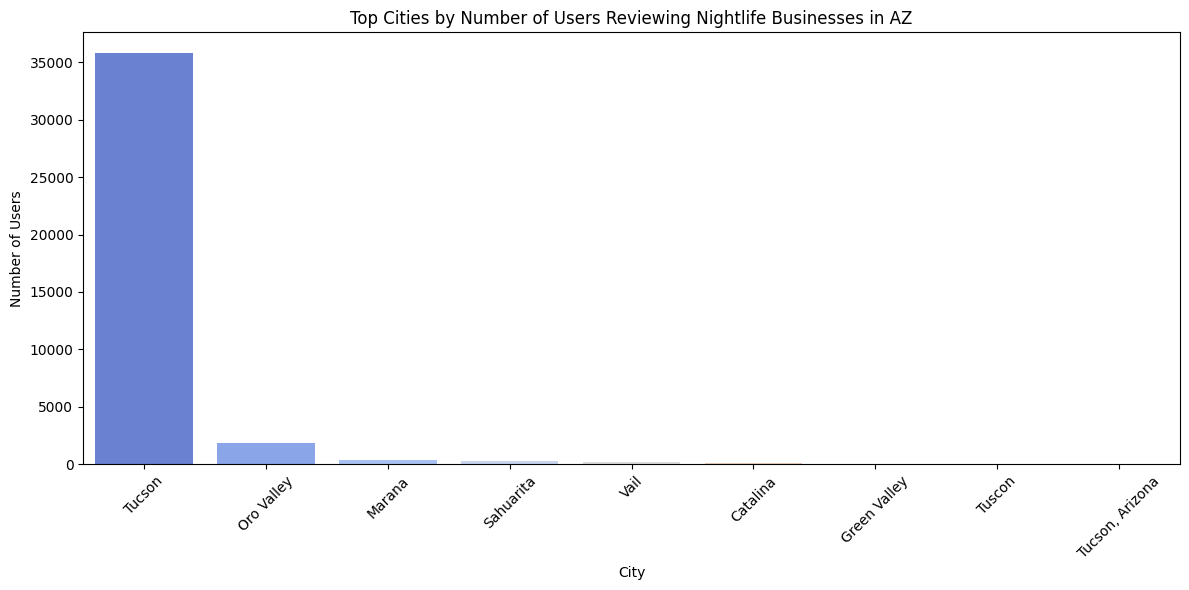

In [16]:
# Query 10: Geographical Distribution of Users Based on Review Activity

query10 = """
SELECT b.city, COUNT(DISTINCT r.user_id) AS user_count
FROM review r
JOIN business b ON r.business_id = b.business_id
GROUP BY b.city
ORDER BY user_count DESC
"""

result4 = spark.sql(query10)
print("Query 10: Geographical Distribution of Users Based on Review Activity")
result4.show(10)

city_users_df = result4.toPandas()
top_cities_df = city_users_df.head(10)

plt.figure(figsize=(12,6))
sns.barplot(x='city', y='user_count', data=top_cities_df, palette='coolwarm')
plt.xlabel('City')
plt.ylabel('Number of Users')
plt.title('Top Cities by Number of Users Reviewing Nightlife Businesses in AZ')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()